Imports and Data Cleaning

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

*Baseline Representation*

In [2]:
df = pd.read_csv("Crime_Data_from_2020_to_Present copy.csv")

In [3]:
df.drop(columns=[
    'Status', 'Status Desc', 'Crm Cd', 'Crm Cd 1', 'Crm Cd 2', 
    'Crm Cd 3', 'Crm Cd 4', 'DR_NO', 'LOCATION', 'Cross Street'
], inplace=True, errors='ignore')

In [4]:
for col in ['Date Rptd', 'DATE OCC']:
    df[col] = pd.to_datetime(df[col], errors='coerce')

/var/folders/_f/fmfry0h146q34wf_0v7085kh0000gn/T/ipykernel_1054/3210269932.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors='coerce')
/var/folders/_f/fmfry0h146q34wf_0v7085kh0000gn/T/ipykernel_1054/3210269932.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors='coerce')


In [5]:
df.dropna(subset=['Crm Cd Desc', 'Vict Age', 'Vict Sex', 'Vict Descent', 'LAT', 'LON'], inplace=True)


In [6]:
df = df[(df['Vict Age'] > 0) & (df['Vict Age'] < 120)]

In [7]:
def simplify_crime_type(desc):
    desc = str(desc).lower()

    # --- Theft / financial crimes ---
    if any(word in desc for word in [
        "theft", "robbery", "burglary", "stolen", "shoplift", "stealing",
        "pickpocket", "purse snatching", "till tap", "forgery", "embezzlement",
        "bunco", "prowler", "larceny", "credit card", "fraud", "counterfeit",
        "document worthless", "stolen property"
    ]):
        return "Theft"

    # --- Assault / violent interpersonal crimes ---
    elif any(word in desc for word in ["assault", "battery", "fighting", "mayhem"]):
        return "Assault"

    # --- Homicide-related ---
    elif any(word in desc for word in ["homicide", "murder", "manslaughter"]):
        return "Homicide"

    # --- Sexual crimes ---
    elif any(word in desc for word in [
        "rape", "sexual", "lewd", "oral copulation", "indecent", "molest",
        "child pornography", "sex", "peeping tom", "pimping"
    ]):
        return "Sexual Crime"

    # --- Property damage / vandalism / trespass ---
    elif any(word in desc for word in [
        "vandalism", "arson", "trespass", "malicious mischief", "graffiti",
        "illegal dumping", "property damage", "telephone"
    ]):
        return "Property Crime"

    # --- Drugs / alcohol ---
    elif any(word in desc for word in ["drunk", "narcotic", "drug", "alcohol", "under influence"]):
        return "Drug/Alcohol"

    # --- Weapons / shootings ---
    elif any(word in desc for word in ["weapon", "firearm", "gun", "shooting", "shots fired"]):
        return "Weapon Offense"

    # --- Kidnapping or abduction ---
    elif any(word in desc for word in ["kidnap", "abduction", "child stealing", "false imprisonment"]):
        return "Kidnapping"

    # --- Threats, harassment, stalking, restraining order, or disruption ---
    elif any(word in desc for word in [
        "threat", "extortion", "stalking", "harass", "intimidation", "restraining order",
        "court order", "contempt", "violation of restraining", "disturbing the peace",
        "disrupt school", "riot", "lynching", "bomb"
    ]):
        return "Threat/Intimidation"

    # --- Vehicle / traffic crimes ---
    elif any(word in desc for word in ["vehicle", "traffic", "hit and run", "failure to yield", "driving"]):
        return "Vehicle Crime"

    # --- Family or child-related crimes ---
    elif any(word in desc for word in [
        "child", "chld", "abandonment", "neglect", "runaway", "custody", "domestic",
        "pandering", "contributing", "cruelty to animals", "family", "disrupt school", "bigamy"
    ]):
        return "Family/Child Issue"

    # --- Cyber / computer crimes ---
    elif any(word in desc for word in ["computer", "cyber", "unauthorized access", "hacking"]):
        return "Cyber Crime"

    # --- Miscellaneous or rare ---
    else:
        return "Other"


In [8]:
# Apply the simplification
df["Crime_Category"] = df["Crm Cd Desc"].apply(simplify_crime_type)

# Check distribution
print(df["Crime_Category"].value_counts())

Crime_Category
Theft                  367298
Assault                197608
Property Crime          76724
Weapon Offense          35269
Threat/Intimidation     25905
Sexual Crime            19388
Other                    4713
Family/Child Issue       3985
Homicide                 1552
Vehicle Crime            1387
Kidnapping               1260
Cyber Crime               463
Drug/Alcohol               44
Name: count, dtype: int64


In [9]:
df["Crime_Category"] = df["Crm Cd Desc"].apply(simplify_crime_type)

In [10]:
df["OCC_Year"] = df["DATE OCC"].dt.year
df["OCC_Month"] = df["DATE OCC"].dt.month
df["OCC_Day"] = df["DATE OCC"].dt.day
df["OCC_Weekday"] = df["DATE OCC"].dt.day_name()
df["OCC_Hour"] = df["TIME OCC"] // 100

In [24]:
demo_cols = ["Vict Age", "Vict Sex", "Vict Descent"]
contextual_cols = ["AREA", "AREA NAME", "Rpt Dist No"]

In [25]:
model_cols = demo_cols + contextual_cols + [
    "Part 1-2", "OCC_Year", "OCC_Month", "OCC_Weekday", "OCC_Hour"
]

df_model = df[model_cols + ["Crime_Category"]].dropna().copy()

In [26]:
print("Shape:", df_model.shape)
print("\nColumns ready for modeling:\n", df_model.columns.tolist())
print("\nTarget distribution:\n", df_model["Crime_Category"].value_counts())

Shape: (735596, 12)

Columns ready for modeling:
 ['Vict Age', 'Vict Sex', 'Vict Descent', 'AREA', 'AREA NAME', 'Rpt Dist No', 'Part 1-2', 'OCC_Year', 'OCC_Month', 'OCC_Weekday', 'OCC_Hour', 'Crime_Category']

Target distribution:
 Crime_Category
Theft                  367298
Assault                197608
Property Crime          76724
Weapon Offense          35269
Threat/Intimidation     25905
Sexual Crime            19388
Other                    4713
Family/Child Issue       3985
Homicide                 1552
Vehicle Crime            1387
Kidnapping               1260
Cyber Crime               463
Drug/Alcohol               44
Name: count, dtype: int64


Pre-processing Steps

In [27]:
X = df_model.drop(columns=["Crime_Category"])
y = df_model["Crime_Category"]

In [28]:
cat_cols = [c for c in X.columns if X[c].dtype == "object"]
num_cols = [c for c in X.columns if np.issubdtype(X[c].dtype, np.number)]

In [29]:
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

In [30]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, stratify=y, random_state=42)

Model 1: Logistic Regression

In [31]:
logreg_pipe = Pipeline([
    ("pre", preprocessor),
    ("model", LogisticRegression(max_iter=300, n_jobs=-1))
])

In [32]:
logreg_pipe.fit(X_train, y_train)
y_pred_logreg = logreg_pipe.predict(X_test)

In [35]:
print("Logistic Regression Results:")
print(classification_report(y_test, y_pred_logreg, zero_division=0))
print("Accuracy:", round(accuracy_score(y_test, y_pred_logreg), 4))

Logistic Regression Results:
                     precision    recall  f1-score   support

            Assault       0.42      0.57      0.49     39522
        Cyber Crime       0.00      0.00      0.00        92
       Drug/Alcohol       0.00      0.00      0.00         9
 Family/Child Issue       0.49      0.36      0.41       797
           Homicide       0.00      0.00      0.00       310
         Kidnapping       0.00      0.00      0.00       252
              Other       0.00      0.00      0.00       943
     Property Crime       0.38      0.12      0.19     15345
       Sexual Crime       0.00      0.00      0.00      3878
              Theft       0.71      0.85      0.77     73460
Threat/Intimidation       0.00      0.00      0.00      5181
      Vehicle Crime       0.00      0.00      0.00       277
     Weapon Offense       0.00      0.00      0.00      7054

           accuracy                           0.59    147120
          macro avg       0.15      0.15      0.14    

Model 2: Gradient Boost

In [37]:
gb_pipe = Pipeline([
    ("pre", preprocessor),
    ("model", GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42))
])

In [39]:
gb_pipe.fit(X_train, y_train)
y_pred_gb = gb_pipe.predict(X_test)

In [40]:
print("Gradient Boosting Results")
print(classification_report(y_test, y_pred_gb, zero_division=0))
print("Accuracy:", round(accuracy_score(y_test, y_pred_gb), 4))

Gradient Boosting Results
                     precision    recall  f1-score   support

            Assault       0.45      0.58      0.50     39522
        Cyber Crime       0.00      0.00      0.00        92
       Drug/Alcohol       0.00      0.00      0.00         9
 Family/Child Issue       0.51      0.37      0.43       797
           Homicide       0.00      0.00      0.00       310
         Kidnapping       0.00      0.00      0.00       252
              Other       1.00      0.00      0.00       943
     Property Crime       0.45      0.19      0.27     15345
       Sexual Crime       0.49      0.06      0.11      3878
              Theft       0.72      0.88      0.79     73460
Threat/Intimidation       0.43      0.00      0.00      5181
      Vehicle Crime       0.31      0.02      0.03       277
     Weapon Offense       0.40      0.00      0.00      7054

           accuracy                           0.62    147120
          macro avg       0.37      0.16      0.16    147

Model 3: Random Forest

In [41]:
rf_pipe = Pipeline([
    ("pre", preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=150, max_depth=15, n_jobs=-1, random_state=42))
])

In [42]:
rf_pipe.fit(X_train, y_train)
y_pred_rf = rf_pipe.predict(X_test)

In [43]:
print("Random Forest Results")
print(classification_report(y_test, y_pred_rf, zero_division=0))
print("Accuracy:", round(accuracy_score(y_test, y_pred_rf), 4))

Random Forest Results
                     precision    recall  f1-score   support

            Assault       0.45      0.58      0.51     39522
        Cyber Crime       0.00      0.00      0.00        92
       Drug/Alcohol       0.00      0.00      0.00         9
 Family/Child Issue       0.71      0.08      0.14       797
           Homicide       0.00      0.00      0.00       310
         Kidnapping       0.00      0.00      0.00       252
              Other       1.00      0.00      0.00       943
     Property Crime       0.55      0.09      0.16     15345
       Sexual Crime       0.66      0.03      0.06      3878
              Theft       0.70      0.89      0.79     73460
Threat/Intimidation       1.00      0.00      0.00      5181
      Vehicle Crime       0.50      0.02      0.04       277
     Weapon Offense       1.00      0.00      0.00      7054

           accuracy                           0.61    147120
          macro avg       0.51      0.13      0.13    147120


Fairness Evaluation 

In [48]:
# Map LAPD Vict Descent codes to full subgroup names (make reading fairness easier)
descent_mapping = {
    "A": "Other Asian",
    "B": "Black",
    "C": "Chinese",
    "D": "Cambodian",
    "F": "Filipino",
    "G": "Guamanian",
    "H": "Hispanic/Latino",
    "I": "American Indian/Alaskan Native",
    "J": "Japanese",
    "K": "Korean",
    "L": "Laotian",
    "O": "Other",
    "P": "Pacific Islander",
    "S": "Samoan",
    "U": "Hawaiian",
    "V": "Vietnamese",
    "W": "White",
    "X": "Unknown",
    "Z": "Asian Indian"
}

df["Vict Descent Full"] = df["Vict Descent"].map(descent_mapping).fillna("Unknown")

In [50]:
# Logistic Regression Fairness
df_logisticreg = pd.DataFrame({
    "y_true" : y_test,
    "y_pred" : y_pred_logreg,
    "group" :  df.loc[y_test.index, "Vict Descent Full"]
})

acc_by_group = df_logisticreg.groupby("group").apply(lambda x: accuracy_score(x.y_true, x.y_pred))
gap = acc_by_group.max() - acc_by_group.min()

print("Fairness Results — Logistic Regression")
print(acc_by_group.sort_values(ascending=False).round(3))
print(f"\nSubgroup Accuracy Gap: {gap:.3f}")

Fairness Results — Logistic Regression
group
Hawaiian                          0.897
Vietnamese                        0.893
Japanese                          0.891
Chinese                           0.891
Cambodian                         0.875
Asian Indian                      0.852
Filipino                          0.833
American Indian/Alaskan Native    0.824
Korean                            0.816
Pacific Islander                  0.811
Unknown                           0.765
Laotian                           0.750
Other Asian                       0.688
Guamanian                         0.688
Samoan                            0.667
White                             0.658
Other                             0.625
Hispanic/Latino                   0.552
Black                             0.507
dtype: float64

Subgroup Accuracy Gap: 0.390


/var/folders/_f/fmfry0h146q34wf_0v7085kh0000gn/T/ipykernel_1054/3538136168.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  acc_by_group = df_logisticreg.groupby("group").apply(lambda x: accuracy_score(x.y_true, x.y_pred))


In [51]:
# Gradient Boost Fairness
df_gb = pd.DataFrame({
    "y_true": y_test,
    "y_pred": y_pred_gb,
    "group": df.loc[y_test.index, "Vict Descent Full"]
})

acc_by_group_gb = df_gb.groupby("group").apply(lambda x: accuracy_score(x.y_true, x.y_pred))
gap_gb = acc_by_group_gb.max() - acc_by_group_gb.min()

print("Fairness Results — Gradient Boosting")
print(acc_by_group_gb.sort_values(ascending=False).round(3))
print(f"\nSubgroup Accuracy Gap: {gap_gb:.3f}")

Fairness Results — Gradient Boosting
group
Vietnamese                        0.915
Chinese                           0.911
Japanese                          0.908
Hawaiian                          0.897
Cambodian                         0.875
Filipino                          0.868
Asian Indian                      0.852
Korean                            0.830
American Indian/Alaskan Native    0.824
Unknown                           0.781
Pacific Islander                  0.774
Other Asian                       0.698
Guamanian                         0.688
White                             0.681
Other                             0.657
Hispanic/Latino                   0.568
Laotian                           0.562
Samoan                            0.556
Black                             0.537
dtype: float64

Subgroup Accuracy Gap: 0.378


/var/folders/_f/fmfry0h146q34wf_0v7085kh0000gn/T/ipykernel_1054/1244400234.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  acc_by_group_gb = df_gb.groupby("group").apply(lambda x: accuracy_score(x.y_true, x.y_pred))


In [52]:
# Random Forest Fairness
df_rf = pd.DataFrame({
    "y_true": y_test,
    "y_pred": y_pred_rf,
    "group": df.loc[y_test.index, "Vict Descent Full"]
})

acc_by_group_rf = df_rf.groupby("group").apply(lambda x: accuracy_score(x.y_true, x.y_pred))
gap_rf = acc_by_group_rf.max() - acc_by_group_rf.min()

print("Fairness Results — Random Forest")
print(acc_by_group_rf.sort_values(ascending=False).round(3))
print(f"\nSubgroup Accuracy Gap: {gap_rf:.3f}")

Fairness Results — Random Forest
group
Vietnamese                        0.902
Chinese                           0.899
Hawaiian                          0.897
Japanese                          0.895
Cambodian                         0.875
Filipino                          0.861
Korean                            0.828
Asian Indian                      0.826
American Indian/Alaskan Native    0.819
Pacific Islander                  0.811
Unknown                           0.803
Other Asian                       0.691
Guamanian                         0.688
White                             0.673
Samoan                            0.667
Other                             0.649
Hispanic/Latino                   0.564
Laotian                           0.562
Black                             0.544
dtype: float64

Subgroup Accuracy Gap: 0.358


/var/folders/_f/fmfry0h146q34wf_0v7085kh0000gn/T/ipykernel_1054/1552847304.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  acc_by_group_rf = df_rf.groupby("group").apply(lambda x: accuracy_score(x.y_true, x.y_pred))


In [53]:
# Overall
fairness_summary = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "Gradient Boosting"],
    "Subgroup Accuracy Gap": [gap, gap_rf, gap_gb]
}).sort_values("Subgroup Accuracy Gap")

print("\nOverall Fairness Comparison:")
print(fairness_summary.round(3))


Overall Fairness Comparison:
                 Model  Subgroup Accuracy Gap
1        Random Forest                  0.358
2    Gradient Boosting                  0.378
0  Logistic Regression                  0.390


Feature Importance

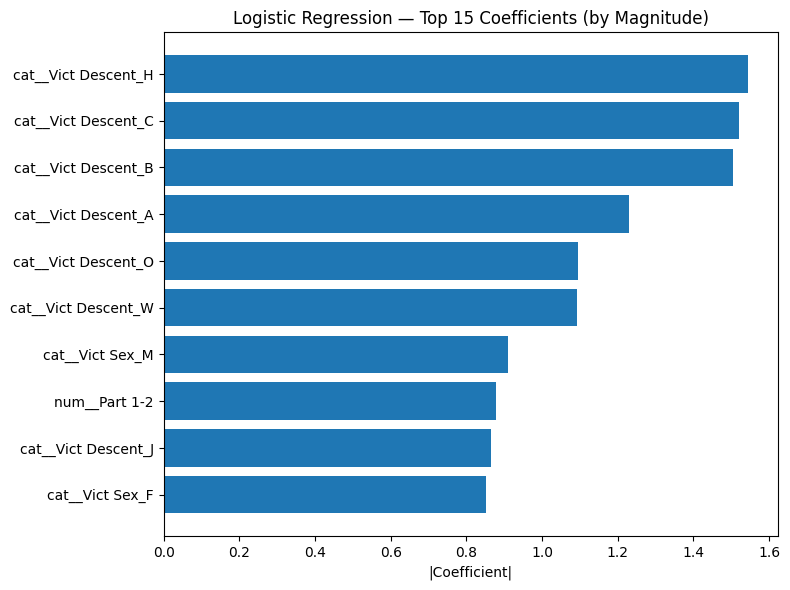

In [59]:
# Logistic Regression 
log_model = logreg_pipe.named_steps["model"]
pre = logreg_pipe.named_steps["pre"]

coefs = log_model.coef_[0]  # one-vs-rest (first class)
feature_names = pre.get_feature_names_out()

idx = np.argsort(np.abs(coefs))[-10:]
plt.figure(figsize=(8,6))
plt.barh(np.array(feature_names)[idx], np.abs(coefs[idx]))
plt.title("Logistic Regression — Top 15 Coefficients (by Magnitude)")
plt.xlabel("|Coefficient|")
plt.tight_layout()
plt.show()

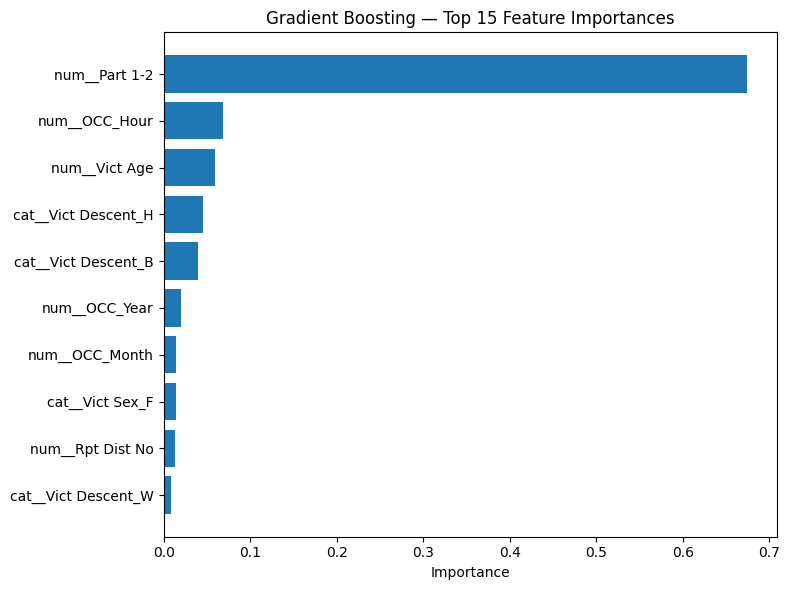

In [58]:
# Gradient Boost 
gb_model = gb_pipe.named_steps["model"]
pre = gb_pipe.named_steps["pre"]

feature_names = pre.get_feature_names_out()
importances = gb_model.feature_importances_

idx = np.argsort(importances)[-10:]
plt.figure(figsize=(8,6))
plt.barh(np.array(feature_names)[idx], importances[idx])
plt.title("Gradient Boosting — Top 15 Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()



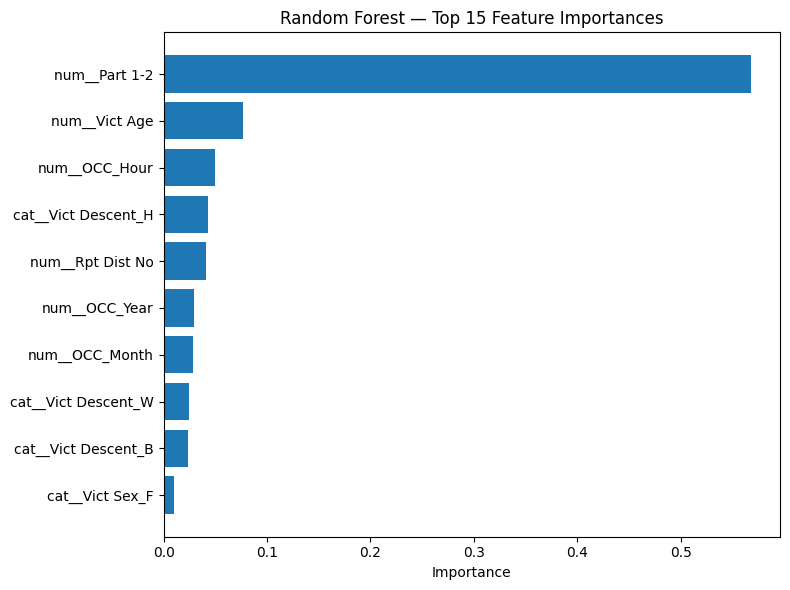

In [57]:
rf_model = rf_pipe.named_steps["model"]
pre = rf_pipe.named_steps["pre"]

feature_names = pre.get_feature_names_out()
importances = rf_model.feature_importances_

# Sort and select top 15
idx = np.argsort(importances)[-10:]
plt.figure(figsize=(8,6))
plt.barh(np.array(feature_names)[idx], importances[idx])
plt.title("Random Forest — Top 15 Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

In [60]:
# Overall Analysis
top_features_rf = pd.DataFrame({
    "Feature": np.array(feature_names)[idx],
    "Importance": importances[idx]
}).sort_values("Importance", ascending=False)

display(top_features_rf)


,Feature,Importance
2,num__Part 1-2,0.674823
9,cat__Vict Descent_H,0.045412
7,cat__Vict Descent_B,0.039791
0,cat__Vict Sex_F,0.014023
4,cat__Vict Descent_W,0.008625
3,cat__Vict Sex_M,0.002304
8,cat__Vict Descent_C,0.001796
1,cat__Vict Descent_J,0.000441
5,cat__Vict Descent_O,0.000111
6,cat__Vict Descent_A,0.000069


*Improved Representation*

In [61]:
df_imp = df.copy()

In [62]:
# Age bins (interpretable)
df_imp["Vict Age Bin"] = pd.cut(
    df_imp["Vict Age"],
    bins=[0, 17, 29, 49, 64, 120],
    labels=["0-17","18-29","30-49","50-64","65+"],
    right=True
)

In [63]:
# Group rare AREA NAMEs
min_freq = 0.01  
area_counts = df_imp["AREA NAME"].value_counts(normalize=True)
rare_areas = area_counts[area_counts < min_freq].index
df_imp["AREA NAME Grouped"] = df_imp["AREA NAME"].where(~df_imp["AREA NAME"].isin(rare_areas), "Other")

In [64]:
# Same datetime features as baseline
df_imp["OCC_Year"] = df_imp["DATE OCC"].dt.year
df_imp["OCC_Month"] = df_imp["DATE OCC"].dt.month
df_imp["OCC_Weekday"] = df_imp["DATE OCC"].dt.day_name()
df_imp["OCC_Hour"] = df_imp["TIME OCC"] // 100

In [65]:
demo_cols_imp = ["Vict Age Bin"]
context_cols_imp = ["AREA", "AREA NAME Grouped", "Rpt Dist No"]

In [66]:
model_cols_imp = demo_cols_imp + context_cols_imp + ["Part 1-2","OCC_Year","OCC_Month","OCC_Weekday","OCC_Hour"]
df_model_improved = df_imp[model_cols_imp + ["Crime_Category","Vict Descent Full"]].dropna().copy()

In [80]:
X_imp = df_model_improved.drop(columns=["Crime_Category", "Vict Descent Full"])
y_imp = df_model_improved["Crime_Category"]
sens_imp = df_model_improved["Vict Descent Full"]

In [81]:
Xtr_imp, Xte_imp, ytr_imp, yte_imp = train_test_split(
    X_imp, y_imp, test_size=0.2, stratify=y_imp, random_state=42
)

Preprocessing

In [83]:
cat_cols_imp = [
    c for c in X_imp.columns 
    if pd.api.types.is_object_dtype(X_imp[c]) or pd.api.types.is_categorical_dtype(X_imp[c])
]

num_cols_imp = [
    c for c in X_imp.columns 
    if pd.api.types.is_numeric_dtype(X_imp[c])
]

/var/folders/_f/fmfry0h146q34wf_0v7085kh0000gn/T/ipykernel_1054/75739588.py:3: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_object_dtype(X_imp[c]) or pd.api.types.is_categorical_dtype(X_imp[c])


In [85]:
pre_imp = ColumnTransformer([
    ("num", StandardScaler(), num_cols_imp),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols_imp)
])

Model 1: Linear Regression

In [86]:
logreg_imp = Pipeline([
    ("pre", pre_imp),
    ("model", LogisticRegression(max_iter=300, n_jobs=-1))
])

In [87]:
logreg_imp.fit(Xtr_imp, ytr_imp)
y_pred_log_imp = logreg_imp.predict(Xte_imp)

In [96]:
print("Linear Regression (Improved)")
print(classification_report(yte_imp, y_pred_log_imp, zero_division=0))
print("Accuracy:", round(accuracy_score(yte_imp, y_pred_log_imp), 4))

Linear Regression (Improved)
                     precision    recall  f1-score   support

            Assault       0.40      0.62      0.48     39522
        Cyber Crime       0.00      0.00      0.00        92
       Drug/Alcohol       0.00      0.00      0.00         9
 Family/Child Issue       0.33      0.00      0.00       797
           Homicide       0.00      0.00      0.00       310
         Kidnapping       0.00      0.00      0.00       252
              Other       0.00      0.00      0.00       943
     Property Crime       0.29      0.03      0.05     15345
       Sexual Crime       0.00      0.00      0.00      3878
              Theft       0.73      0.83      0.78     73460
Threat/Intimidation       0.00      0.00      0.00      5181
      Vehicle Crime       0.00      0.00      0.00       277
     Weapon Offense       0.00      0.00      0.00      7054

           accuracy                           0.58    147120
          macro avg       0.13      0.11      0.10    

Model 2: Gradient Boost 

In [88]:
gb_imp = Pipeline([
    ("pre", pre_imp),
    ("model", GradientBoostingClassifier(
        n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42))
])

In [89]:
gb_imp.fit(Xtr_imp, ytr_imp)
y_pred_gb_imp = gb_imp.predict(Xte_imp)

In [95]:
print("Gradient Boost (Improved)")
print(classification_report(yte_imp, y_pred_gb_imp, zero_division=0))
print("Accuracy:", round(accuracy_score(yte_imp, y_pred_gb_imp), 4))

Gradient Boost (Improved)
                     precision    recall  f1-score   support

            Assault       0.43      0.59      0.50     39522
        Cyber Crime       0.00      0.00      0.00        92
       Drug/Alcohol       0.00      0.00      0.00         9
 Family/Child Issue       0.36      0.04      0.06       797
           Homicide       0.00      0.00      0.00       310
         Kidnapping       0.00      0.00      0.00       252
              Other       0.00      0.00      0.00       943
     Property Crime       0.45      0.10      0.17     15345
       Sexual Crime       0.51      0.03      0.05      3878
              Theft       0.72      0.87      0.79     73460
Threat/Intimidation       0.00      0.00      0.00      5181
      Vehicle Crime       0.00      0.00      0.00       277
     Weapon Offense       0.00      0.00      0.00      7054

           accuracy                           0.61    147120
          macro avg       0.19      0.13      0.12    147

Model 3: Random Forest (Improved)

In [97]:
rf_imp = Pipeline([
    ("pre", pre_imp),
    ("model", RandomForestClassifier(
        n_estimators=150, max_depth=15, n_jobs=-1, random_state=42))
])

In [98]:
rf_imp.fit(Xtr_imp, ytr_imp)
y_pred_rf_imp = rf_imp.predict(Xte_imp)

In [99]:
print("Random Forest (Improved)")
print(classification_report(yte_imp, y_pred_rf_imp, zero_division=0))
print("Accuracy:", round(accuracy_score(yte_imp, y_pred_rf_imp), 4))

Random Forest (Improved)
                     precision    recall  f1-score   support

            Assault       0.43      0.59      0.50     39522
        Cyber Crime       0.00      0.00      0.00        92
       Drug/Alcohol       0.00      0.00      0.00         9
 Family/Child Issue       0.51      0.03      0.05       797
           Homicide       0.00      0.00      0.00       310
         Kidnapping       0.00      0.00      0.00       252
              Other       0.00      0.00      0.00       943
     Property Crime       0.53      0.06      0.11     15345
       Sexual Crime       0.56      0.02      0.04      3878
              Theft       0.71      0.88      0.79     73460
Threat/Intimidation       1.00      0.00      0.00      5181
      Vehicle Crime       0.00      0.00      0.00       277
     Weapon Offense       1.00      0.00      0.00      7054

           accuracy                           0.61    147120
          macro avg       0.37      0.12      0.11    1471

Fairness Report

In [103]:
# Logistic Regression Fairness (Improved)
df_logreg_imp = pd.DataFrame({
    "y_true": yte_imp,
    "y_pred": y_pred_log_imp,
    "group": sens_imp.loc[yte_imp.index]
})

acc_by_group = df_logreg_imp.groupby("group").apply(lambda x: accuracy_score(x.y_true, x.y_pred))
gap_log_imp = acc_by_group.max() - acc_by_group.min()

print("Fairness Results — Logistic Regression (Improved)")
print(acc_by_group.sort_values(ascending=False).round(3))
print(f"\nSubgroup Accuracy Gap: {gap:.3f}")

Fairness Results — Logistic Regression (Improved)
group
Hawaiian                          0.828
Guamanian                         0.812
Chinese                           0.799
Japanese                          0.783
Asian Indian                      0.765
Vietnamese                        0.765
Filipino                          0.728
Pacific Islander                  0.717
Korean                            0.717
American Indian/Alaskan Native    0.691
Other Asian                       0.690
Cambodian                         0.688
White                             0.651
Unknown                           0.636
Other                             0.626
Hispanic/Latino                   0.547
Black                             0.508
Laotian                           0.500
Samoan                            0.444
dtype: float64

Subgroup Accuracy Gap: 0.425


/var/folders/_f/fmfry0h146q34wf_0v7085kh0000gn/T/ipykernel_1054/3148775432.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  acc_by_group = df_logreg_imp.groupby("group").apply(lambda x: accuracy_score(x.y_true, x.y_pred))


In [105]:
# Gradient Boosting Fairness (Improved)
df_gb_imp = pd.DataFrame({
    "y_true": yte_imp,
    "y_pred": y_pred_gb_imp,
    "group": sens_imp.loc[yte_imp.index]
})

acc_by_group = df_gb_imp.groupby("group").apply(lambda x: accuracy_score(x.y_true, x.y_pred))
gap_gb_imp = acc_by_group.max() - acc_by_group.min()

print("Fairness Results — Gradient Boosting (Improved)")
print(acc_by_group.sort_values(ascending=False).round(3))
print(f"\nSubgroup Accuracy Gap: {gap:.3f}")

Fairness Results — Gradient Boosting (Improved)
group
Hawaiian                          0.862
Japanese                          0.832
Chinese                           0.818
Guamanian                         0.812
Vietnamese                        0.803
Asian Indian                      0.791
Filipino                          0.786
Korean                            0.745
American Indian/Alaskan Native    0.739
Pacific Islander                  0.717
Other Asian                       0.700
Cambodian                         0.688
Unknown                           0.677
White                             0.674
Other                             0.649
Hispanic/Latino                   0.565
Samoan                            0.556
Black                             0.534
Laotian                           0.500
dtype: float64

Subgroup Accuracy Gap: 0.425


/var/folders/_f/fmfry0h146q34wf_0v7085kh0000gn/T/ipykernel_1054/1195594417.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  acc_by_group = df_gb_imp.groupby("group").apply(lambda x: accuracy_score(x.y_true, x.y_pred))


In [104]:
# Random Forest Fairness (Improved)
df_rf_imp = pd.DataFrame({
    "y_true": yte_imp,
    "y_pred": y_pred_rf_imp,
    "group": sens_imp.loc[yte_imp.index]
})

acc_by_group = df_rf_imp.groupby("group").apply(lambda x: accuracy_score(x.y_true, x.y_pred))
gap_rf_imp = acc_by_group.max() - acc_by_group.min()

print("Fairness Results — Random Forest (Improved)")
print(acc_by_group.sort_values(ascending=False).round(3))
print(f"\nSubgroup Accuracy Gap: {gap:.3f}")

Fairness Results — Random Forest (Improved)
group
Hawaiian                          0.862
Japanese                          0.832
Chinese                           0.819
Cambodian                         0.812
Guamanian                         0.812
Asian Indian                      0.809
Vietnamese                        0.795
Filipino                          0.771
American Indian/Alaskan Native    0.761
Korean                            0.741
Pacific Islander                  0.717
Other Asian                       0.695
Unknown                           0.686
White                             0.673
Other                             0.647
Hispanic/Latino                   0.565
Samoan                            0.556
Black                             0.542
Laotian                           0.438
dtype: float64

Subgroup Accuracy Gap: 0.425


/var/folders/_f/fmfry0h146q34wf_0v7085kh0000gn/T/ipykernel_1054/2486120672.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  acc_by_group = df_rf_imp.groupby("group").apply(lambda x: accuracy_score(x.y_true, x.y_pred))


In [106]:
# Overall Fairness Summary
fairness_summary = pd.DataFrame({
    "Model": ["Logistic Regression (Improved)", "Random Forest (Improved)", "Gradient Boosting (Improved)"],
    "Subgroup Accuracy Gap": [gap_log_imp, gap_rf_imp, gap_gb_imp]
}).sort_values("Subgroup Accuracy Gap")

print("\nOverall Fairness Comparison:")
print(fairness_summary.round(3))



Overall Fairness Comparison:
                            Model  Subgroup Accuracy Gap
2    Gradient Boosting (Improved)                  0.362
0  Logistic Regression (Improved)                  0.383
1        Random Forest (Improved)                  0.425


Feature Importance

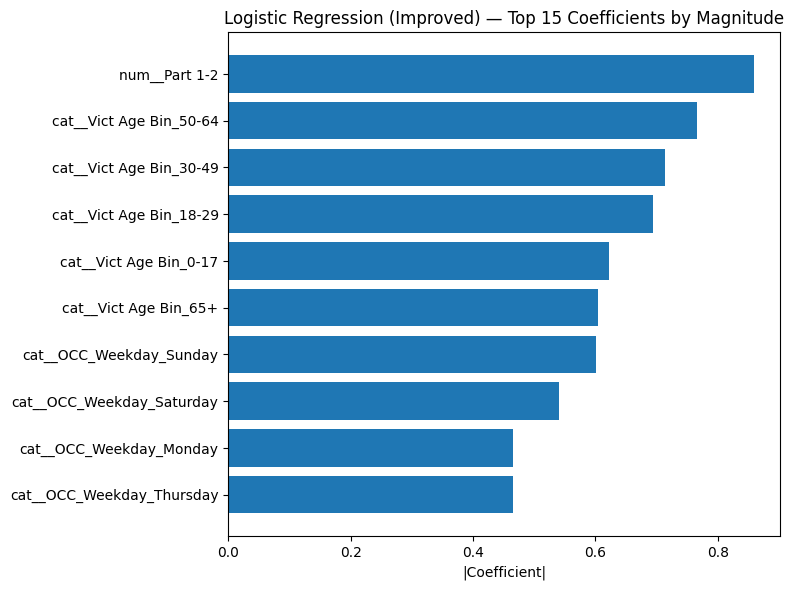

In [109]:
# Logistic Regression
log_model = logreg_imp.named_steps["model"]
pre = logreg_imp.named_steps["pre"]

feature_names = pre.get_feature_names_out()
coefs = log_model.coef_[0]

idx = np.argsort(np.abs(coefs))[-10:]
plt.figure(figsize=(8,6))
plt.barh(np.array(feature_names)[idx], np.abs(coefs[idx]))
plt.title("Logistic Regression (Improved) — Top 15 Coefficients by Magnitude")
plt.xlabel("|Coefficient|")
plt.tight_layout()
plt.show()

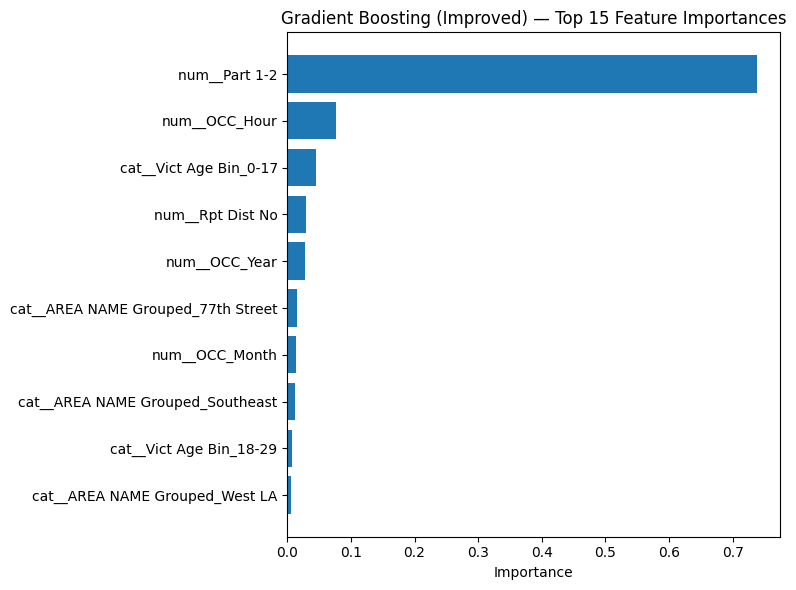

In [111]:
# Gradient Boosting
gb_model = gb_imp.named_steps["model"]
pre = gb_imp.named_steps["pre"]

feature_names = pre.get_feature_names_out()
importances = gb_model.feature_importances_

idx = np.argsort(importances)[-10:]
plt.figure(figsize=(8,6))
plt.barh(np.array(feature_names)[idx], importances[idx])
plt.title("Gradient Boosting (Improved) — Top 15 Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

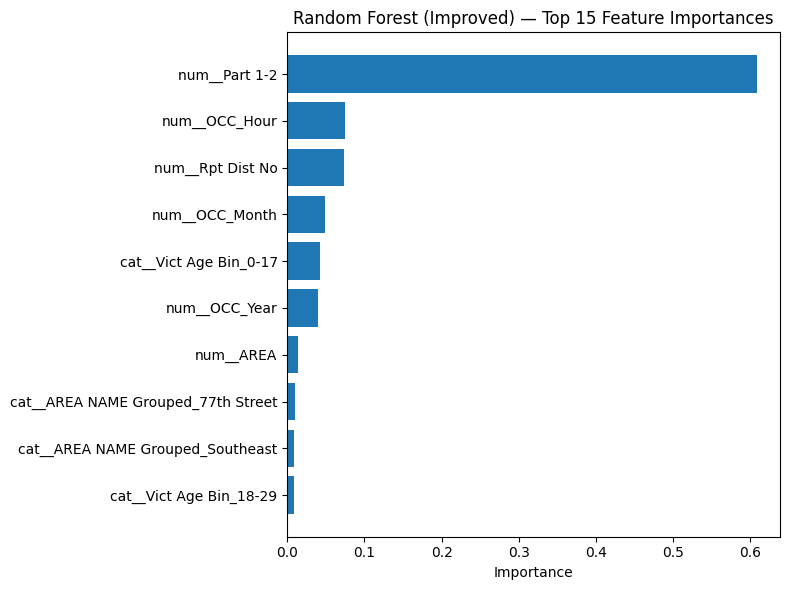

In [112]:
rf_model = rf_imp.named_steps["model"]
pre = rf_imp.named_steps["pre"]

feature_names = pre.get_feature_names_out()
importances = rf_model.feature_importances_

idx = np.argsort(importances)[-10:]
plt.figure(figsize=(8,6))
plt.barh(np.array(feature_names)[idx], importances[idx])
plt.title("Random Forest (Improved) — Top 15 Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


*Comparing Baseline to Improved*

In [113]:
report = classification_report(yte_imp, y_pred_log_imp, output_dict=True, zero_division=0)
f1_log_imp = report["weighted avg"]["f1-score"]
acc_log_imp = report["accuracy"]

In [115]:
# Extracting Report from Baseline

# Logistic Regression (Baseline)
report_log = classification_report(y_test, y_pred_logreg, output_dict=True, zero_division=0)
acc_log = report_log["accuracy"]
f1_log = report_log["weighted avg"]["f1-score"]

# Random Forest (Baseline)
report_rf = classification_report(y_test, y_pred_rf, output_dict=True, zero_division=0)
acc_rf = report_rf["accuracy"]
f1_rf = report_rf["weighted avg"]["f1-score"]

# Gradient Boosting (Baseline)
report_gb = classification_report(y_test, y_pred_gb, output_dict=True, zero_division=0)
acc_gb = report_gb["accuracy"]
f1_gb = report_gb["weighted avg"]["f1-score"]

In [116]:
# Extracting Report from Improved

# Logistic Regression (Improved)
report_log_imp = classification_report(yte_imp, y_pred_log_imp, output_dict=True, zero_division=0)
acc_log_imp = report_log_imp["accuracy"]
f1_log_imp = report_log_imp["weighted avg"]["f1-score"]

# Random Forest (Improved)
report_rf_imp = classification_report(yte_imp, y_pred_rf_imp, output_dict=True, zero_division=0)
acc_rf_imp = report_rf_imp["accuracy"]
f1_rf_imp = report_rf_imp["weighted avg"]["f1-score"]

# Gradient Boosting (Improved)
report_gb_imp = classification_report(yte_imp, y_pred_gb_imp, output_dict=True, zero_division=0)
acc_gb_imp = report_gb_imp["accuracy"]
f1_gb_imp = report_gb_imp["weighted avg"]["f1-score"]

In [118]:
df_logisticreg = pd.DataFrame({
    "y_true" : y_test,
    "y_pred" : y_pred_logreg,
    "group" :  df.loc[y_test.index, "Vict Descent Full"]
})
acc_by_group = df_logisticreg.groupby("group").apply(lambda x: accuracy_score(x.y_true, x.y_pred))
gap = acc_by_group.max() - acc_by_group.min()


/var/folders/_f/fmfry0h146q34wf_0v7085kh0000gn/T/ipykernel_1054/4128503130.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  acc_by_group = df_logisticreg.groupby("group").apply(lambda x: accuracy_score(x.y_true, x.y_pred))


In [119]:
gap_log = gap   # after Logistic Regression baseline fairness
gap_rf = gap    # after Random Forest baseline fairness
gap_gb = gap    # after Gradient Boosting baseline fairness


In [121]:
comparison_df = pd.DataFrame({
    "Model": [
        "Logistic Regression (Baseline)", "Logistic Regression (Improved)",
        "Random Forest (Baseline)", "Random Forest (Improved)",
        "Gradient Boosting (Baseline)", "Gradient Boosting (Improved)"
    ],
    "Accuracy": [
        acc_log, acc_log_imp,
        acc_rf, acc_rf_imp,
        acc_gb, acc_gb_imp
    ],
    "F1-Score": [
        f1_log, f1_log_imp,
        f1_rf, f1_rf_imp,
        f1_gb, f1_gb_imp
    ],
    "Fairness Gap": [
        gap_log, gap_log_imp,
        gap_rf, gap_rf_imp,
        gap_gb, gap_gb_imp
    ]
})
comparison_df.round(3)


,Model,Accuracy,F1-Score,Fairness Gap
0,Logistic Regression (Baseline),0.594,0.539,0.390
1,Logistic Regression (Improved),0.585,0.523,0.383
2,Random Forest (Baseline),0.613,0.548,0.390
3,Random Forest (Improved),0.608,0.541,0.425
4,Gradient Boosting (Baseline),0.616,0.565,0.390
5,Gradient Boosting (Improved),0.607,0.548,0.362


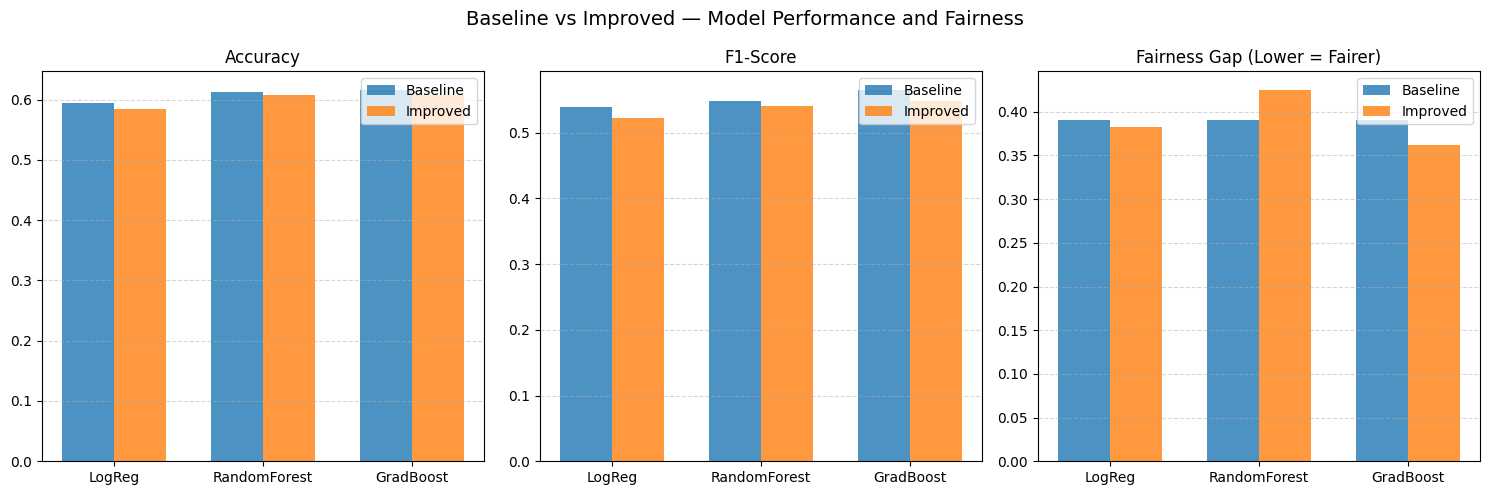

In [122]:
# Baseline vs Improved Visualizations

models = ["LogReg", "RandomForest", "GradBoost"]
x = np.arange(len(models))
width = 0.35

acc_baseline = [0.594, 0.613, 0.616]
acc_improved = [0.585, 0.608, 0.607]

f1_baseline = [0.539, 0.548, 0.565]
f1_improved = [0.523, 0.541, 0.548]

gap_baseline = [0.390, 0.390, 0.390]
gap_improved = [0.383, 0.425, 0.362]

fig, axes = plt.subplots(1, 3, figsize=(15,5))
titles = ["Accuracy", "F1-Score", "Fairness Gap (Lower = Fairer)"]
metrics = [(acc_baseline, acc_improved),
           (f1_baseline, f1_improved),
           (gap_baseline, gap_improved)]

for ax, (baseline, improved), title in zip(axes, metrics, titles):
    ax.bar(x - width/2, baseline, width, label="Baseline", alpha=0.8)
    ax.bar(x + width/2, improved, width, label="Improved", alpha=0.8)
    ax.set_xticks(x)
    ax.set_xticklabels(models)
    ax.set_title(title)
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.suptitle("Baseline vs Improved — Model Performance and Fairness", fontsize=14)
plt.tight_layout()
plt.show()
